In [477]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras
from keras import backend as K
import tensorflow as tf

In [478]:
# create some data
n_samples = 100
X = np.random.uniform(low=-2.,high=2.,size=(n_samples,1))
y = 1.5*np.sin(np.pi*X[:,0]) + np.random.normal(loc=0.,scale=1.*np.power(X[:,0],2))
y = y.reshape([-1,1])/5.
X_train = X.reshape(-1)
y_train = y.reshape(-1)
y_train = np.stack((y_train,y_train),axis=1) # make this 2d so will be accepted
x_grid = np.linspace(-2,2,100) # for evaluation plots

In [479]:
# hyperparameters
lambda_ = 0.01 # lambda in loss fn
alpha_ = 0.05  # capturing (1-alpha)% of samples
soften_ = 160.
n_ = 100 # batch size

# define loss fn
def qd_objective(y_true, y_pred):
    '''Loss_QD-soft, from algorithm 1'''
    y_true = y_true[:,0]
    y_u = y_pred[:,0]
    y_l = y_pred[:,1]
    
    K_HU = tf.maximum(0.,tf.sign(y_u - y_true))
    K_HL = tf.maximum(0.,tf.sign(y_true - y_l))
    K_H = tf.multiply(K_HU, K_HL)
    
    K_SU = tf.sigmoid(soften_ * (y_u - y_true))
    K_SL = tf.sigmoid(soften_ * (y_true - y_l))
    K_S = tf.multiply(K_SU, K_SL)
    
    MPIW_c = tf.reduce_sum(tf.multiply((y_u - y_l),K_H))/tf.reduce_sum(K_H)
    PICP_H = tf.reduce_mean(K_H)
    PICP_S = tf.reduce_mean(K_S)
    
    Loss_S = MPIW_c + lambda_ * n_ / (alpha_*(1-alpha_)) * tf.maximum(0.,(1-alpha_) - PICP_S)
    
    return Loss_S

In [480]:
# set up model
model = Sequential()
model.add(Dense(100, input_dim=1, activation='relu',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.2)))
model.add(Dense(2, activation='linear',
                kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.3), 
                bias_initializer=keras.initializers.Constant(value=[3.,-3.]))) # important to init biases to start!

# compile
opt = keras.optimizers.Adam(lr=0.02, decay=0.01)
model.compile(loss=qd_objective, optimizer=opt)

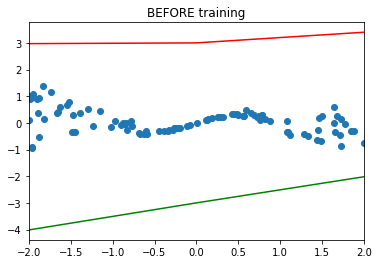

In [481]:
# plot and view some predictions
y_pred = model.predict(x_grid, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]

plt.scatter(X_train,y_train[:,0])
plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction
plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction
plt.title('BEFORE training')
plt.xlim(-2,2)
plt.show()

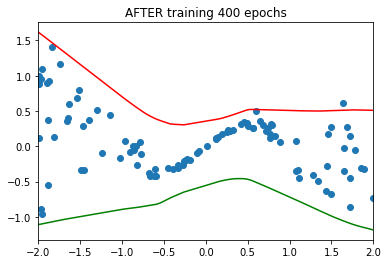

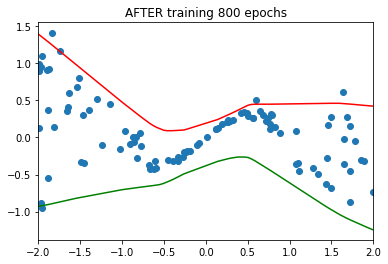

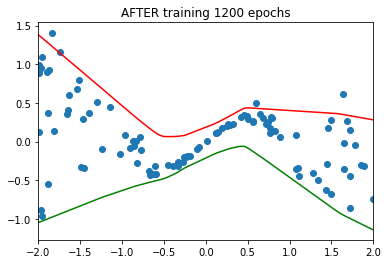

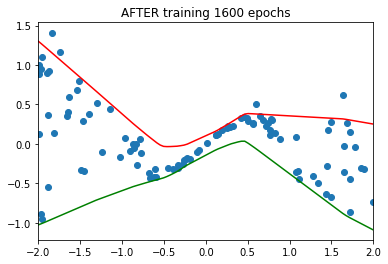

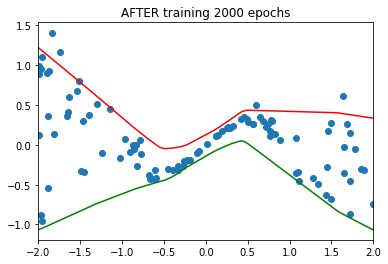

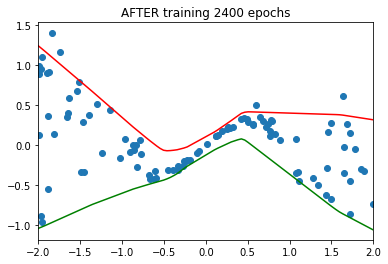

In [482]:
result_loss=[]
for i in range(6):
    result = model.fit(X_train, y_train, epochs=400, batch_size=n_, verbose=0,  validation_split=0.)
    result_loss.append(result.history['loss'])
    
    # plot and view some predictions
    y_pred = model.predict(x_grid, verbose=0)
    y_u_pred = y_pred[:,0]
    y_l_pred = y_pred[:,1]

    plt.scatter(X_train,y_train[:,0])
    plt.plot(x_grid, y_u_pred, color='r') # upper boundary prediction
    plt.plot(x_grid, y_l_pred, color='g') # lower boundary prediction
    plt.title('AFTER training '+str((i+1)*400)+' epochs')
    plt.xlim(-2,2)
    plt.show()

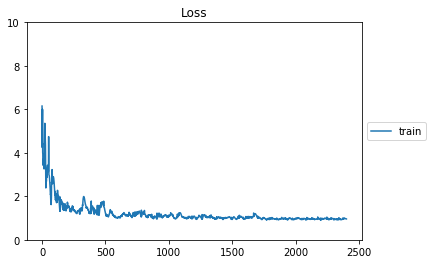

In [483]:
# view training
result_loss = np.array(result_loss).reshape(-1)
x = range(result_loss.shape[0])
plt.plot(x, result_loss, label='train')
plt.title('Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(0,10)
plt.show()

In [484]:
# print some stats
y_pred = model.predict(X_train, verbose=0)
y_u_pred = y_pred[:,0]
y_l_pred = y_pred[:,1]
K_u = y_u_pred > y_train[:,0]
K_l = y_l_pred < y_train[:,0]
print('PICP:', np.mean(K_u * K_l))
print('MPIW:', np.round(np.mean(y_u_pred - y_l_pred),3))

PICP: 0.96
MPIW: 0.977
